# Statistical Rethinking Ch 2 Bayesian Modeling
> Implementing and adding extra materials and contents from statistical rethinking course/book

- toc: true
- badges: true
- comments: true
- categories: [jupyter, bayesian, stats_rethinking]
- metadata_key1: bayesian
- metadata_key2: jupyter

# About
- [Statistical rethinking](https://xcelab.net/rm/statistical-rethinking/) is an excellent book/course about Bayesian learning for beginners.
- I would recommend:
  1. Read the chapter
  2. Watch the youtube video for the corresponding chapter
  3. Implement and run the code

> Important: I would highly recommend spending some time on Chapter 2 and 3 as they are the foundations

## Corresponding Youtube Video
> youtube: https://www.youtube.com/watch?v=XoVtOAN0htU&list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI&index=2

# Chapter 2
## Overview
- Chapter 2 covers the basics of Bayesian inference. It's pretty much summarized in one sentence as indicated below. I will not cover this part so if you are not sure what the following means, check the textbook and the youtube video.

> Important: Bayesian inference is really just counting and comparing of possibilities.

- This chapter also covers Bayesian modeling. This is the fundamental part that I'm going to cover and spend most time on.

## Bayesian Modeling
- Problem statement:
  1. Randomly sample a point from a world map
  2. Is the point land(=L) or water(=W)? There's nothing else. It has to be either L or W. So it's binomial.
  3. Can we figure out a good estimate of the world from these samples?
    - For example, given the collected samples, how much portion of the world is water? 30%? 60%?

In [1]:
#hide
import jax.numpy as np
import numpyro
import numpyro.distributions as dist

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]
sns.set_style("darkgrid")
sns.set_context("talk")

In [2]:
#hide
def calculate_posterior(total_count, water_count):
    # Don't worry about these equations for now as
    # I'll explain these in detail later
    probability_grid = np.linspace(start=0, stop=1, num=100)
    prior = np.ones(100)
    likelihood = np.exp(
        dist.Binomial(
            total_count=total_count,
            probs=probability_grid
        ).log_prob(water_count)
    )
    unstandardized_posterior = likelihood * prior
    posterior = unstandardized_posterior / np.sum(unstandardized_posterior)
    return probability_grid, posterior

### Sample N = 1
Let's start from the beginning. You randomly sampled a sample from the world map. It was water(=W). To understand the world with probability, we could try plotting the probability of water vs plausibility plot like below.

Don't worry about understanding the code now as I'll go through them later.

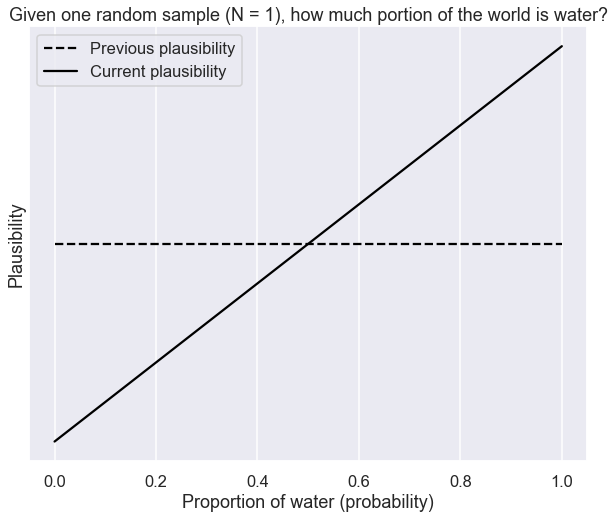

In [3]:
#collapse-hide
# calculate posterior given 1 randomly sampled data
p_grid, posterior = calculate_posterior(total_count=1, water_count=1)
# calculate the previous posterior
prev_posterior = np.repeat(np.mean(posterior), 100)
# plot the previous posterior
plt.plot(p_grid, prev_posterior, "--", color='k')
# plot the current posterior
plt.plot(p_grid, posterior, "-", color="k")
# some other stuff
plt.legend(['Previous plausibility', 'Current plausibility'])
plt.xlabel("Proportion of water (probability)")
plt.yticks([])
plt.ylabel("Plausibility")
plt.title("Given one random sample (N = 1), how much portion of the world is water?");

Let me explain about this figure a bit. First, you have proportion of water or probability of water in the x-axis. You have the plausibility that tells you how likely that is the case in the y-axis. Check out the previous plausibility. This is shown as a dashed line. Previous plausibility means before randomly sampling anything. You have no idea what's the plausibility of water with respect to (w.r.t.) the proportion of water. In other words, every proportion in x-axis is likely plausible before sampling anything and that's why it's a straight line.

Next, look at the current plausibility. Things have changed here. Now you have one sample, which was water(=W) out of N = 1 total sample. Notice that now the plausibility w.r.t. the proportion of water = 0 is zero. Why? because you observed that there is water by sampling water. Therefore, there's no way the proportion of water is zero now. Don't worry if you don't get it by now, let's look at the next example.

### Sample N = 2
Previously, we sampled water(=W). With one sample, it's impossible to understand the underlying probability distribution of the problem. Let's keep sampling to understand more about the world. This time, you sampled land(=L). So now you have W, L, two samples.

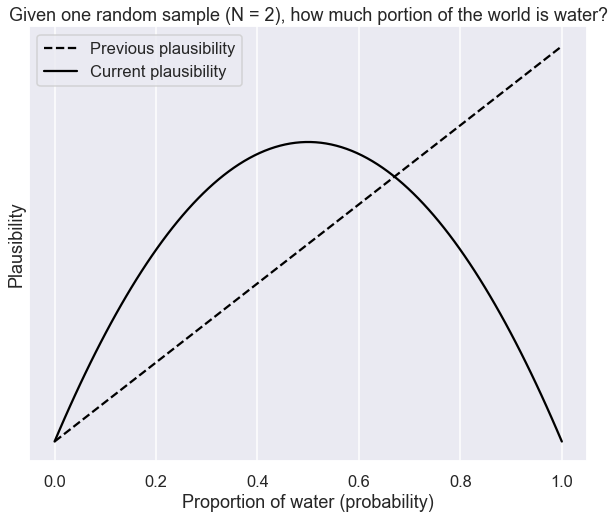

In [4]:
#collapse-hide
# get previous posterior
prev_posterior = posterior
# calculate posterior given 1 randomly sampled data
p_grid, posterior = calculate_posterior(total_count=2, water_count=1)
# plot the previous posterior
plt.plot(p_grid, prev_posterior, "--", color='k')
# plot the current posterior
plt.plot(p_grid, posterior, "-", color="k")
# some other stuff
plt.legend(['Previous plausibility', 'Current plausibility'])
plt.xlabel("Proportion of water (probability)")
plt.yticks([])
plt.ylabel("Plausibility")
plt.title("Given one random sample (N = 2), how much portion of the world is water?");

It's becoming more interesting. At the second sample, you observed land(=L) and you have already observed water(=W) in the first sample. Now you know that the plausibility w.r.t. the proportion of water = 1 is zero too. Why? Think this way. If the world is covered with full of water with no land, then yeah surely the proportion of water = 1 is plausible. But in that case, you won't observe land. Since you observed land in the second sample, this distopian scenario of the world covered with full of water is no longer valid. Thank god!

Instead, what's more plausible is the proportion of water = 0.5. This is because out of 2 samples, you have 1 water and 1 land. It's like flipping a coin now. Without knowing what's a coin is, but you were told that you have 1 head and 1 tail, how do approximate the probability of the next one being head? Probably 50:50, right?

### Sample N = 3 to 9
From here on, you should be able to pretty much understand what the plot indicates. Take some time to see if the below plots make sense to you given the sequences of samples: W, L, W, W, W, L, W, L, W

So now you have 9 samples in total. Of which 6 water and 3 land.

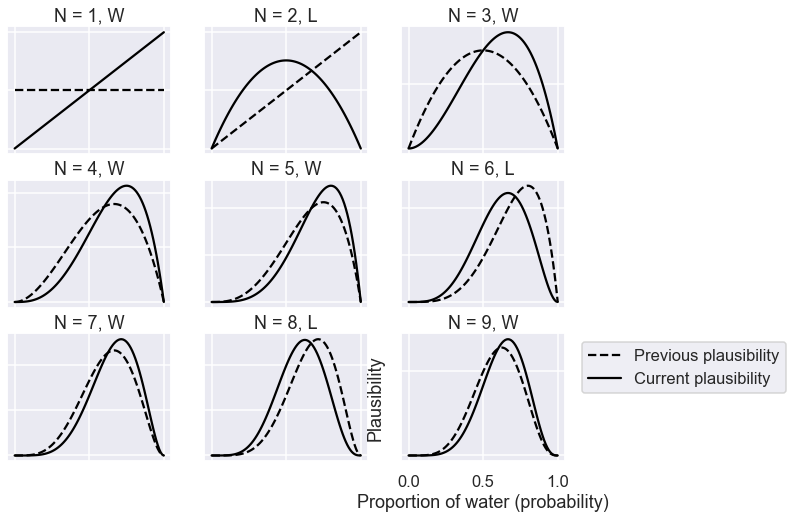

In [5]:
#collapse-hide
rest_of_samples = ['W', 'L', 'W', 'W', 'W', 'L', 'W', 'L', 'W']
prev_total = 0
prev_water = 0
# calculate the previous posterior
posterior = np.repeat(1/100, 100)
f, axes = plt.subplots(3, 3)
for i in range(9):
    s = rest_of_samples[i]
    if i < 3:
        x_idx = 0
        y_idx = i
    elif i >= 3 and i < 6:
        x_idx = 1
        y_idx = i - 3
    else:
        x_idx = 2
        y_idx = i - 6
    prev_total += 1
    if s == 'W':
        prev_water += 1
    # get previous posterior
    prev_posterior = posterior
    # calculate posterior given 1 randomly sampled data
    p_grid, posterior = calculate_posterior(total_count=prev_total, water_count=prev_water)
    # plot the previous posterior
    ax = axes[x_idx, y_idx]
    ax.plot(p_grid, prev_posterior, "--", color='k')
    # plot the current posterior
    ax.plot(p_grid, posterior, "-", color="k")
    ax.set_yticklabels([])
    # some other stuff
    if i == len(rest_of_samples) - 1:
        ax.legend(['Previous plausibility', 'Current plausibility'], bbox_to_anchor=(1.05, 1), loc=2,)
        plt.xlabel("Proportion of water (probability)")
        plt.ylabel("Plausibility")
    else:
        ax.set_xticklabels([])
    title_txt = "N = " + str(prev_total) + ", " + s
    ax.set_title(title_txt)

You can now see that every time we get a sample (either L or W), the probability distribution gets updated to represent the underlying distribution of the world as accurate as it can (I'll talk about how exactly to calculate these in a moment). If you look at the last N = 9, you see the peak somewhere around 0.65 ish. This should be intuitive because you got 6 W out of 9 total samples. Which is 6/9 = 0.666... The most likely representation of the world given only 9 samples.

## Breaking down Bayesian modeling
By now, you might be wondering. "Yeah, I think I got the concept. It's a toy problem. Easy! But how exactly can we compute and plot the graph?"

This is the section with equations.

You might already know the Bayes rule:

$$\underbrace{P(A|B)}_\text{Posterior}
=\frac{\overbrace{P(B|A)}^\text{Likelihood} \times \overbrace{P(A)}^\text{Prior}}{\underbrace{P(B)}_\text{Marginal}}$$

In the figures above, all I was doing is the following:
1. Calculate the likelihood given the new sample
2. Calculate the prior (or get the previous posterior)
3. Multiply the two
4. Divide it by the marginal to standardize so it becomes posterior probability

### Likelihood
First, let's get started with likelihood. Likelihood is described as
> Important: a mathematical formula that specified the plausibility of the data.

In the toy example, given the assumption that each of the random sampling is independent from each other and the probability of getting a sample does not change (the world doesn't change), we could treat the problem as the binomial distribution.

$$Pr(x|n,p) = \frac{n!}{(n-x)!x!} p^x (1-p)^{n-x}$$

where
- $x$: the count of an event (e.g. water)
- $n$: total count of events
- $p$: probability of getting $x$

In [6]:
# Define the distribution with parameters
d = dist.Binomial(total_count=9, probs=0.5)
# Say we drew 6 samples out of 9 total samples
x = 6
# Evaluate log probability of x
p = d.log_prob(x)
# Convert back to a normal probability by taking the exponential
likelihood = np.exp(p)
# Now all together
likelihood = np.exp(dist.Binomial(total_count=9, probs=0.5).log_prob(6))
print(likelihood)

0.16406256


Note that for the probability of p, we are just setting it to 0.5 here. This corresponds to the x-axis (proportion of water) in the previous plots. Imagine calculating the likelihood at a certain point in x-axis which is 0.5. The above value in likelihood is the likelihood of water if the probability of water appearing is 0.5 and we sampled 6 water out of 9 total samples.

### Prior
Now the prior. This is where you can give some information about the prior distribution, usually determined by the assumption you have about the data. I talked a bit before in the plot with example N = 1 where the dashed line was flat. This was because before sampling anything, there's no information about the world, so the plausibility of water in any probability is equally likely = flat line.

We can model this flat line as an uniform distribution:

$$Pr(p) = \frac{1}{b - a}$$

where
- $a$: minimum probability
- $b$: maximum probability

### Marginal

This part is easy as it's just the factor to normalize as you can see in the Bayes rule I already showed you.

In other words, the following Bayes rule can be written in a different format

$$\underbrace{P(A|B)}_\text{Posterior}
=\frac{\overbrace{P(B|A)}^\text{Likelihood} \times \overbrace{P(A)}^\text{Prior}}{\underbrace{P(B)}_\text{Marginal}}$$

when thinking the marginal as a normalization factor, it's written like this:

$$\underbrace{P(A|B)}_\text{Posterior}
=\frac{\overbrace{P(B|A)}^\text{Likelihood} \times \overbrace{P(A)}^\text{Prior}}{\underbrace{\sum P(B|A)P(A)}_\text{Marginal}}$$

Now you have all the components to calculate the posterior. Let's move on to 3 ways of calculating the posteriors using the above equations.